# Notebook to check the data before and after ´Cellbender´

# Importing packages

In [2]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                 10.3.0
asttokens           NA
cffi                1.16.0
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
defusedxml          0.7.1
django              5.0.6
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.5
ipython_genutils    0.2.0
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.10.1
numpy               2.0.0
packaging           24.1
pandas              2.2.2
parso               0.8.4
patsy               0.5.6
platformdirs        4.2.2
plotly    

# Before Cellbender

In [5]:
base_dir = '/home/skolla/Github/hofmann_dmd/raw_data'
sample_dirs = ['A9_2', 'A10_2', 'A11_2', 'A12_2','B1_2', 'B2_2']
umi_before_cellbender = '/home/skolla/Github/hofmann_dmd/raw_data/umi_plots_before_cellbender/'
low_umi_dir = '/home/skolla/Github/hofmann_dmd/raw_data/low_umi_data'
cellbender_data = '/home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient'

## H5ad file generation

#### Steps

1. Define paths
2. Create a loop to follow path and read the files
3. Read each sample files and write the h5ad file 

In [ ]:
for sample in sample_dirs:
    sample_path = os.path.join(base_dir, sample, 'raw_feature_bc_matrix')
    adata = sc.read_10x_mtx(sample_path, var_names='gene_symbols', cache=True)
    
    adata.write(base_dir + '/raw_anndatas/'+ f'{sample}.h5ad')

    print(f'Converted {sample} to {sample}.h5ad')

## UMI plot generation

#### Steps

1. Read raw anndata files
2. Ensure that adata.X is dense for calculations
3. Calculate total UMI counts for each cell

In [ ]:
for sample in sample_dirs:

    adata = sc.read_h5ad(base_dir + '/raw_anndatas/'+ f'{sample}.h5ad')

    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()
        
    total_counts = np.sum(adata.X, axis=1)

    plt.figure(figsize = (10,8))
    plt.hist(total_counts,bins= 300)
    plt.xlabel('UMI Counts')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title(f'Histogram of UMI Counts per Cell Before Cellbender - {sample}')
    plt.grid(True)
    plt.savefig(umi_before_cellbender + f'UMI before cellbender:{sample}')
    plt.show()

    print(f"Total counts in {sample}: {len(total_counts)}")

## Seperating cells below desired UMI - Indices, barcodes and genes

#### Steps

1. Create a dictionary to store genes for cells with UMI counts < 200 per sample
2. Load data and Ensure that adata.X is dense for calculations
3. Calculate total UMI counts for each cell
4. Filter cells with UMI counts below 200 and save indices in file
5. Extract genes for cells with UMI counts < 200 and extract genes of those cells and save as a file
6. Remove duplicates by converting to set
7. Get barcodes for cells with UMI counts < 200 and save as a file

In [ ]:
low_count_genes_200 = {}
low_count_cells_indices_200 = {}

for sample in sample_dirs:
    
    adata = sc.read_h5ad(os.path.join(base_dir, 'raw_anndatas', f'{sample}.h5ad'))

    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()

    total_counts = np.sum(adata.X, axis=1)

    low_count_cells_indices_200[sample] = np.where(total_counts < 200)[0]
    low_count_genes_200[sample] = []
    
    for cell_idx in low_count_cells_indices_200[sample]:
        genes_expressed = adata.var_names[np.where(adata.X[cell_idx] > 0)[0]]
        low_count_genes_200[sample].extend(genes_expressed)

    indices_file = os.path.join(low_umi_dir, f"low_count_cells_indices_{sample}_200.txt")
    with open(indices_file, "w") as file:
        file.write("\n".join(map(str, low_count_cells_indices_200[sample])))

    low_count_genes_200[sample] = list(set(low_count_genes_200[sample]))
    genes_file = os.path.join(low_umi_dir, f"low_count_genes_{sample}_200.txt")
    with open(genes_file, "w") as file:
        file.write("\n".join(low_count_genes_200[sample]))

    low_count_cells_barcodes = adata.obs_names[low_count_cells_indices_200[sample]].tolist()
    barcodes_file = os.path.join(low_umi_dir, f"low_count_cells_barcodes_{sample}_200.txt")
    with open(barcodes_file, "w") as file:
        file.write("\n".join(low_count_cells_barcodes))


    # Print confirmation
    print(f"Saved data for {sample} in {low_umi_dir}")
    print(f"Sample: {sample}")
    print(f"Number of cells with UMI counts < 200: {len(low_count_cells_indices_200[sample])}")
    print(f"Genes expressed in cells with UMI counts < 200: {low_count_genes_200[sample]}")
    print()

#### Steps

1. Create a dictionary to store genes for cells with UMI counts < 500 per sample
2. Load data and Ensure that adata.X is dense for calculations
3. Calculate total UMI counts for each cell
4. Filter cells with UMI counts below 500 and save indices in file
5. Extract genes for cells with UMI counts < 500 and extract genes of those cells and save as a file
6. Remove duplicates by converting to set
7. Get barcodes for cells with UMI counts < 500 and save as a file

In [ ]:
low_count_genes_500 = {}
low_count_cells_indices_500 = {}

for sample in sample_dirs:
    
    adata = sc.read_h5ad(os.path.join(base_dir, 'raw_anndatas', f'{sample}.h5ad'))

    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()

    total_counts = np.sum(adata.X, axis=1)

    low_count_cells_indices_500[sample] = np.where(total_counts < 500)[0]
    low_count_genes_500[sample] = []
    
    for cell_idx in low_count_cells_indices_500[sample]:
        genes_expressed = adata.var_names[np.where(adata.X[cell_idx] > 0)[0]]
        low_count_genes_500[sample].extend(genes_expressed)

    indices_file = os.path.join(low_umi_dir, f"low_count_cells_indices_{sample}_500.txt")
    with open(indices_file, "w") as file:
        file.write("\n".join(map(str, low_count_cells_indices_500[sample])))

    low_count_genes_500[sample] = list(set(low_count_genes_500[sample]))
    genes_file = os.path.join(low_umi_dir, f"low_count_genes_{sample}_500.txt")
    with open(genes_file, "w") as file:
        file.write("\n".join(low_count_genes_500[sample]))

    low_count_cells_barcodes = adata.obs_names[low_count_cells_indices_500[sample]].tolist()
    barcodes_file = os.path.join(low_umi_dir, f"low_count_cells_barcodes_{sample}_500.txt")
    with open(barcodes_file, "w") as file:
        file.write("\n".join(low_count_cells_barcodes))


    # Print confirmation
    print(f"Saved data for {sample} in {low_umi_dir}")
    print(f"Sample: {sample}")
    print(f"Number of cells with UMI counts < 500: {len(low_count_cells_indices_500[sample])}")
    print(f"Genes expressed in cells with UMI counts < 500: {low_count_genes_500[sample]}")
    print()

# After Cellbender

## UMI plot generation

#### Steps

1. Read raw anndata files
2. Ensure that adata.X is dense for calculations
3. Calculate total UMI counts for each cell

In [ ]:
for sample in sample_dirs:
    
    adata = sc.read_10x_h5(cellbender_data + f'/{sample}/{sample}_filtered.h5')

    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()

    total_counts = np.sum(adata.X, axis=1)

    plt.figure(figsize = (10,8))
    plt.hist(total_counts,bins= 300)
    plt.xlabel('UMI Counts')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title(f'Histogram of UMI Counts per Cell After Cellbender - {sample}')
    plt.grid(True)
    plt.savefig((f'UMI after cellbender:{sample}'))
    plt.show()

    print(f"Total counts in {sample}: {len(total_counts)}")

## Looking at overlapping data - barcodes, genes

#### Steps

1. Load cellbender data
2. Extract barcodes from CellBender data
3. Load file having low_umi_genes per sample
4. Read barcodes from the ambient RNA data
5. Convert barcodes to sets for efficient comparison
6. Find common barcodes

In [6]:
for sample in sample_dirs:
    
    cb_filtered_file = os.path.join(cellbender_data + f'/{sample}/{sample}_filtered.h5')
    cb_adata = sc.read_10x_h5(cb_filtered_file)

    cb_barcodes = cb_adata.obs_names.tolist()

    ambient_genes_file = os.path.join(low_umi_dir, f"low_count_cells_barcodes_{sample}_200.txt")

    if os.path.exists(ambient_genes_file):

        with open(ambient_genes_file, "r") as file:
            ambient_barcodes = file.read().strip().split("\n")
    else:
        print(f"Ambient RNA data file not found for {sample}")
        continue

    cb_barcodes_set = set(cb_barcodes)
    ambient_barcodes_set = set(ambient_barcodes)

    common_barcodes = cb_barcodes_set.intersection(ambient_barcodes_set)
    num_common_barcodes = len(common_barcodes)

    print(f"Sample: {sample}")
    print(f"Number of barcodes in CellBender filtered data: {len(cb_barcodes)}")
    print(f"Number of barcodes in Ambient RNA data: {len(ambient_barcodes)}")
    print(f"Number of common barcodes: {num_common_barcodes}")
    print(f"Percentage of common barcodes in CellBender data: {num_common_barcodes / len(cb_barcodes) * 100:.2f}%")
    print(f"Percentage of common barcodes in Ambient RNA data: {num_common_barcodes / len(ambient_barcodes) * 100:.2f}%")
    print()


reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A9_2/A9_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A9_2
Number of barcodes in CellBender filtered data: 9395
Number of barcodes in Ambient RNA data: 1463642
Number of common barcodes: 0
Percentage of common barcodes in CellBender data: 0.00%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A10_2/A10_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A10_2
Number of barcodes in CellBender filtered data: 63842
Number of barcodes in Ambient RNA data: 1449629
Number of common barcodes: 1181
Percentage of common barcodes in CellBender data: 1.85%
Percentage of common barcodes in Ambient RNA data: 0.08%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A11_2/A11_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A11_2
Number of barcodes in CellBender filtered data: 15232
Number of barcodes in Ambient RNA data: 1856094
Number of common barcodes: 0
Percentage of common barcodes in CellBender data: 0.00%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A12_2/A12_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A12_2
Number of barcodes in CellBender filtered data: 12754
Number of barcodes in Ambient RNA data: 1688465
Number of common barcodes: 0
Percentage of common barcodes in CellBender data: 0.00%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B1_2/B1_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: B1_2
Number of barcodes in CellBender filtered data: 66372
Number of barcodes in Ambient RNA data: 1822258
Number of common barcodes: 414
Percentage of common barcodes in CellBender data: 0.62%
Percentage of common barcodes in Ambient RNA data: 0.02%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B2_2/B2_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: B2_2
Number of barcodes in CellBender filtered data: 21041
Number of barcodes in Ambient RNA data: 1399692
Number of common barcodes: 151
Percentage of common barcodes in CellBender data: 0.72%
Percentage of common barcodes in Ambient RNA data: 0.01%



In [7]:
for sample in sample_dirs:

    cb_filtered_file = os.path.join(cellbender_data + f'/{sample}/{sample}_filtered.h5')
    cb_adata = sc.read_10x_h5(cb_filtered_file)

    cb_barcodes = cb_adata.obs_names.tolist()

    ambient_genes_file = os.path.join(low_umi_dir, f"low_count_cells_barcodes_{sample}_500.txt")

    if os.path.exists(ambient_genes_file):
       
        with open(ambient_genes_file, "r") as file:
            ambient_barcodes = file.read().strip().split("\n")
    else:
        print(f"Ambient RNA data file not found for {sample}")
        continue

    cb_barcodes_set = set(cb_barcodes)
    ambient_barcodes_set = set(ambient_barcodes)

    common_barcodes = cb_barcodes_set.intersection(ambient_barcodes_set)
    num_common_barcodes = len(common_barcodes)

    print(f"Sample: {sample}")
    print(f"Number of barcodes in CellBender filtered data: {len(cb_barcodes)}")
    print(f"Number of barcodes in Ambient RNA data: {len(ambient_barcodes)}")
    print(f"Number of common barcodes: {num_common_barcodes}")
    print(f"Percentage of common barcodes in CellBender data: {num_common_barcodes / len(cb_barcodes) * 100:.2f}%")
    print(f"Percentage of common barcodes in Ambient RNA data: {num_common_barcodes / len(ambient_barcodes) * 100:.2f}%")
    print()


reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A9_2/A9_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A9_2
Number of barcodes in CellBender filtered data: 9395
Number of barcodes in Ambient RNA data: 1464384
Number of common barcodes: 0
Percentage of common barcodes in CellBender data: 0.00%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A10_2/A10_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A10_2
Number of barcodes in CellBender filtered data: 63842
Number of barcodes in Ambient RNA data: 1453586
Number of common barcodes: 5138
Percentage of common barcodes in CellBender data: 8.05%
Percentage of common barcodes in Ambient RNA data: 0.35%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A11_2/A11_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A11_2
Number of barcodes in CellBender filtered data: 15232
Number of barcodes in Ambient RNA data: 1909204
Number of common barcodes: 0
Percentage of common barcodes in CellBender data: 0.00%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A12_2/A12_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: A12_2
Number of barcodes in CellBender filtered data: 12754
Number of barcodes in Ambient RNA data: 1744747
Number of common barcodes: 16
Percentage of common barcodes in CellBender data: 0.13%
Percentage of common barcodes in Ambient RNA data: 0.00%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B1_2/B1_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: B1_2
Number of barcodes in CellBender filtered data: 66372
Number of barcodes in Ambient RNA data: 1846623
Number of common barcodes: 24778
Percentage of common barcodes in CellBender data: 37.33%
Percentage of common barcodes in Ambient RNA data: 1.34%

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B2_2/B2_2_filtered.h5
 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample: B2_2
Number of barcodes in CellBender filtered data: 21041
Number of barcodes in Ambient RNA data: 1403039
Number of common barcodes: 3498
Percentage of common barcodes in CellBender data: 16.62%
Percentage of common barcodes in Ambient RNA data: 0.25%



#### Steps

1. Load cellbender data
2. Extract genes from CellBender data
3. Load file having low_umi_genes per sample
4. Read genes from the ambient RNA data
5. Convert genes to sets for efficient comparison
6. Find common barcodes

In [ ]:
for sample in sample_dirs:

    cb_filtered_file = os.path.join(cellbender_data + f'{sample}_cleaned_fpr0.005_filtered.h5')
    cb_adata = sc.read_10x_h5(cb_filtered_file)
    cb_adata = cb_filtered_file[total_counts >= 2000]

    cb_barcodes = cb_adata.var_names.tolist()

    ambient_genes_file = os.path.join(low_umi_dir, f"low_count_genes_{sample}_200.txt")

    if os.path.exists(ambient_genes_file):
        with open(ambient_genes_file, "r") as file:
            ambient_barcodes = file.read().strip().split("\n")
    else:
        print(f"Ambient RNA data file not found for {sample}")
        continue

    cb_barcodes_set = set(cb_barcodes)
    ambient_barcodes_set = set(ambient_barcodes)

    common_barcodes = cb_barcodes_set.intersection(ambient_barcodes_set)
    num_common_barcodes = len(common_barcodes)

    print(f"Sample: {sample}")
    print(f"Number of Genes in CellBender filtered data: {len(cb_barcodes)}")
    print(f"Number of Genes in Ambient RNA data: {len(ambient_barcodes)}")
    print(f"Number of common Genes: {num_common_barcodes}")
    print(f"Percentage of common Genes in CellBender data: {num_common_barcodes / len(cb_barcodes) * 100:.2f}%")
    print(f"Percentage of common Genes in Ambient RNA data: {num_common_barcodes / len(ambient_barcodes) * 100:.2f}%")
    print()


In [ ]:
for sample in sample_dirs:

    cb_filtered_file = os.path.join(cellbender_data+ f'{sample}_cleaned_fpr0.005_filtered.h5')
    cb_adata = sc.read_10x_h5(cb_filtered_file)
    cb_adata = cb_filtered_file[total_counts >= 2000]
    
    cb_barcodes = cb_adata.var_names.tolist()

    ambient_genes_file = os.path.join(low_umi_dir, f"low_count_genes_{sample}_500.txt")

    if os.path.exists(ambient_genes_file):
        with open(ambient_genes_file, "r") as file:
            ambient_barcodes = file.read().strip().split("\n")
    else:
        print(f"Ambient RNA data file not found for {sample}")
        continue

    cb_barcodes_set = set(cb_barcodes)
    ambient_barcodes_set = set(ambient_barcodes)

    common_barcodes = cb_barcodes_set.intersection(ambient_barcodes_set)
    num_common_barcodes = len(common_barcodes)

    print(f"Sample: {sample}")
    print(f"Number of Genes in CellBender filtered data: {len(cb_barcodes)}")
    print(f"Number of Genes in Ambient RNA data: {len(ambient_barcodes)}")
    print(f"Number of common Genes: {num_common_barcodes}")
    print(f"Percentage of common Genes in CellBender data: {num_common_barcodes / len(cb_barcodes) * 100:.2f}%")
    print(f"Percentage of common Genes in Ambient RNA data: {num_common_barcodes / len(ambient_barcodes) * 100:.2f}%")
    print()


# Filtered Cellbender data 

reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A9_2/A9_2_filtered.h5
 (0:00:00)
reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A10_2/A10_2_filtered.h5


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A11_2/A11_2_filtered.h5
 (0:00:00)
reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/A12_2/A12_2_filtered.h5


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B1_2/B1_2_filtered.h5


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /home/skolla/Github/hofmann_dmd/cellbender/0.03_ambient/B2_2/B2_2_filtered.h5


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


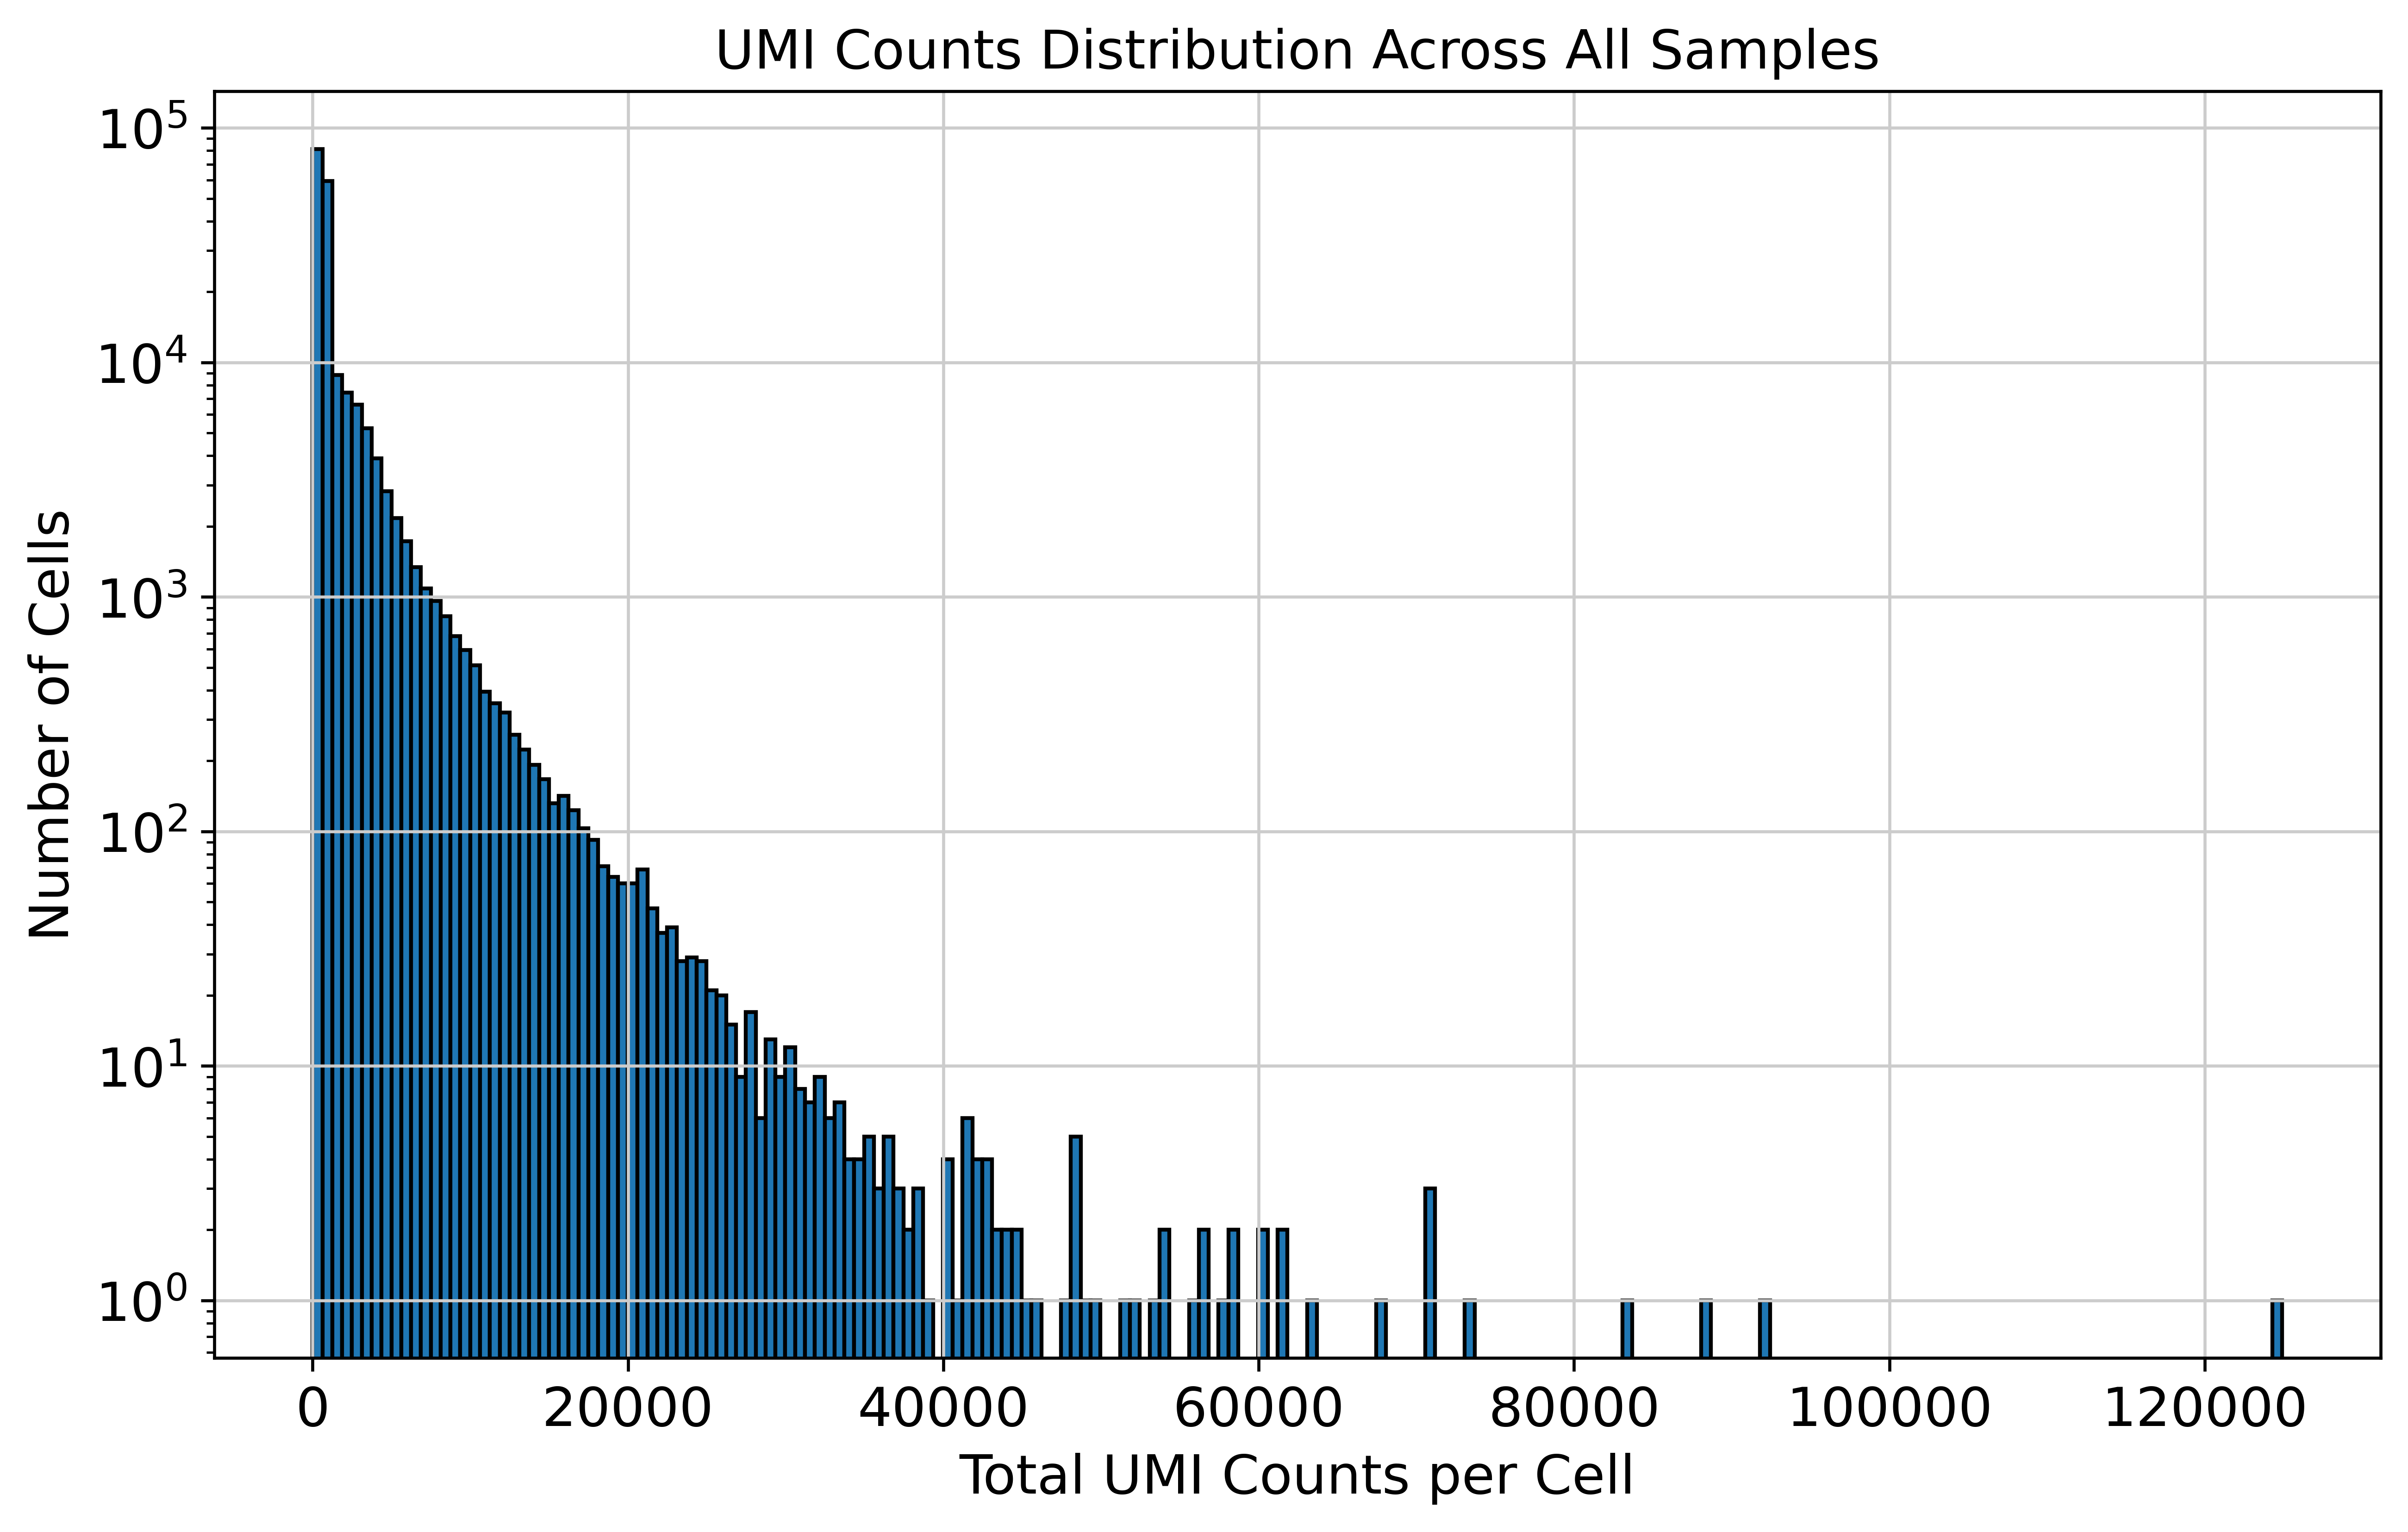

In [14]:
sample_files = [f'/{sample}/{sample}_filtered.h5' for sample in ['A9_2', 'A10_2', 'A11_2', 'A12_2', 'B1_2', 'B2_2']]

adatas = []
for sample, sample_file in zip(['A9_2', 'A10_2', 'A11_2', 'A12_2', 'B1_2', 'B2_2'], sample_files):
    adata = sc.read_10x_h5(os.path.join(cellbender_data +  sample_file))
    adata.obs_names = [f"{barcode}-{sample}" for barcode in adata.obs_names]
    adata.var_names_make_unique() 
    adatas.append(adata)

combined_adata = sc.concat(adatas, label='sample', keys=['A9_2', 'A10_2', 'A11_2', 'A12_2', 'B1_2', 'B2_2'])

if not isinstance(combined_adata.X, np.ndarray):
    combined_adata.X = combined_adata.X.toarray()

total_counts = np.sum(combined_adata.X, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(total_counts, bins=200, edgecolor='black')
plt.title('UMI Counts Distribution Across All Samples')
plt.xlabel('Total UMI Counts per Cell')
plt.ylabel('Number of Cells')
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
raw_adata_file = os.path.join(base_dir,'raw_anndatas', f'{sample}.h5ad')
raw_adata = sc.read_h5ad(raw_adata_file)

plt.figure(figsize=(12, 6))
plt.hist(np.log1p(np.sum(raw_adata.X, axis=1)), bins=50, alpha=0.5, label='Raw Data')
plt.hist(np.log1p(np.sum(combined_adata.X, axis=1)), bins=50, alpha=0.5, label='After Cellbender')
plt.xlabel('Log(UMI Counts)')
plt.ylabel('Number of Cells')
plt.title('Comparison of UMI Counts Distribution')
plt.legend()
plt.show()

In [ ]:
file_path = os.path.join(cellbender_data, 'combined_filtered_cellbender.h5ad')
combined_adata.write_h5ad(file_path)

# Processed data

In [8]:
file_paths = [
    "heart_mm_nuclei-23-0092_CMC_states_ctl240131.raw.h5ad",
    "heart_mm_nuclei-23-0092_scANVI-Lymphoid_states_ctl240527.raw.h5ad",
    "heart_mm_nuclei-23-0092_scANVI-vascular_states_ctl240131.raw.h5ad",
    "heart_mm_nuclei-23-0092_FB_states_ctl240131.raw.h5ad",
    "heart_mm_nuclei-23-0092_scANVI-Myeloid_states_ctl240502.raw.h5ad"
]

adata_list = []
for file_path in file_paths:
    full_path = "/home/skolla/Github/hofmann_dmd/data/" + file_path
    adata = sc.read(full_path)
    adata_list.append(adata)

# Merge all AnnData objects
labelled_merged = adata_list[0].concatenate(adata_list[1:], join='inner')

# Save merged AnnData object
labelled_merged.write('annotated_merged_data.h5ad')

/tmp/ipykernel_1479565/984484062.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  labelled_merged = adata_list[0].concatenate(adata_list[1:], join='inner')


In [16]:
labelled_merged

AnnData object with n_obs × n_vars = 147345 × 16060
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'mt-0', 'ribo-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-DMD_immune-DMD-1', 'feature_types-DMD_immune-DMD-1', 'genome-DMD_immune-DMD-1', 

In [9]:
labelled_merged.obs['cell_type'].value_counts()

cell_type
CD4Tnaive        26482
NK               11156
CD8Tnaive        10600
MHCII+MØtr        8702
NØ                6975
MØinf             6756
Ly6CloMo          6212
CD4Th             4856
TLF+MØ            4683
CD8Tctl           2880
Isg15+MØ          2845
B_cells           2087
B_naive           1703
Ly6ChiMo          1691
CD8Tcm            1584
DC2               1394
Mast              1376
T                 1149
CD8Temra          1048
Ccr2+MHCII+MØ      949
B_mem              751
gdT                385
Treg               363
CD4Tctl            280
ILC                195
DC                 105
Spp1+Gpnmb+MØ       28
CD8Tem              15
Plasma_cells         9
MAIT                 1
Name: count, dtype: int64

In [10]:
# Filter cells based on cell type annotations
cell_types_of_interest = ['B_cells', 'B_mem', 'B_naive', 'T']

barcodes_of_interest = {}

for cell_type in cell_types_of_interest:
    # Extract barcodes for the current cell type
    barcodes = labelled_merged[labelled_merged.obs['cell_type'] == cell_type].obs.index.tolist()
    barcodes_of_interest[cell_type] = barcodes

barcodes_of_interest

{'B_cells': ['TATTGGGCACATTACG-1-A10_2-1',
  'CACAACACACCTAAAC-1-A10_2-1',
  'CTCCAACGTGGCCTCA-1-A10_2-1',
  'AGGCTGCAGACATAGT-1-A10_2-1',
  'CAGCGTGGTACAGAAT-1-A10_2-1',
  'TCGACCTCAGCTAACT-1-A10_2-1',
  'GGGTATTCATTACTCT-1-A10_2-1',
  'CCTTGTGCAAATGCGG-1-A10_2-1',
  'CAACGATGTGGACCAA-1-A10_2-1',
  'GGGCCATGTTCGCGTG-1-A10_2-1',
  'TCCTCTTCATGTTCGA-1-A10_2-1',
  'TCAGTCCGTACGGTTT-1-A10_2-1',
  'GACTGATTCTCGTTTA-1-A10_2-1',
  'GACGCTGAGCGTACAG-1-A10_2-1',
  'CGAAGTTGTGGCGTAA-1-A10_2-1',
  'CTCAGAAGTAGCGAGT-1-A10_2-1',
  'GGGTTATCATGGCACC-1-A10_2-1',
  'TCGCTTGCATGACAAA-1-A10_2-1',
  'TACCCGTCACGCTGTG-1-A10_2-1',
  'AACGAAAGTGCTCGTG-1-A10_2-1',
  'TGTTCCGCACGCGTGT-1-A10_2-1',
  'GTTGTAGTCAGCCTTC-1-A10_2-1',
  'ACTTATCGTAGGACTG-1-A10_2-1',
  'TCATCATGTAGACGTG-1-A10_2-1',
  'CAGGCCACAATACAGA-1-A10_2-1',
  'ATGGGTTGTGGACAGT-1-A10_2-1',
  'GCGGATCCAAATTAGG-1-A10_2-1',
  'ACGTAACTCGTACACA-1-A10_2-1',
  'AGCTTCCCAGAGTGTG-1-A10_2-1',
  'GCCGTGACATGTGACT-1-A10_2-1',
  'ACATCGATCTCTTCAA-1-A10_2-1

In [11]:
cleaned_barcodes_of_interest = {}

for cell_type, barcodes in barcodes_of_interest.items():
    cleaned_barcodes = []
    for barcode in barcodes:
        # Split the barcode by '-1'
        parts = barcode.split('-1')
        # Join the first part and '-1' if there was at least one split
        if len(parts) > 1:
            cleaned_barcode = '-1'.join(parts[:2])  # Join the first part and '-1'
        else:
            cleaned_barcode = barcode  # If no '-1' found, keep the original barcode
        cleaned_barcodes.append(cleaned_barcode)
    cleaned_barcodes_of_interest[cell_type] = cleaned_barcodes

cleaned_barcodes

['AAAGAACTCCCGTGTT-1_1-MDX_POOL_NEW',
 'CATGGTACACCTTCCA-1_1-MDX_POOL_NEW',
 'GTGCAGCGTAGGAGGG-1_1-MDX_POOL_NEW',
 'GTAGAAAGTACCTAGT-1-A10_2',
 'TGTACAGCAGAGTCTT-1-A10_2',
 'TAGTGCAAGAGATTCA-1-A10_2',
 'ATTCACTAGGGCATGT-1-A10_2',
 'AGGCATTGTGTCTAAC-1-A10_2',
 'AATCGTGAGGTAAACT-1-A10_2',
 'GTCGAATGTCCTATAG-1-A10_2',
 'CGAGGCTCACGTAGTT-1-A10_2',
 'CACAGATCATTCGATG-1-A10_2',
 'TTTCATGCAGAAATCA-1-A10_2',
 'CGGGTCAAGAGTCGAC-1-A10_2',
 'GTCGTAACATGTTCGA-1-A10_2',
 'TCATTACGTTAGGAGC-1-A10_2',
 'GAGTTGTGTTTACGTG-1-A10_2',
 'AAGCGAGAGGCATTTC-1-A10_2',
 'GCTCAAAAGCGTGTCC-1-A10_2',
 'TATACCTTCATGCAGT-1-A10_2',
 'AGTACTGGTCTAACGT-1-A10_2',
 'CAGAGCCTCATTTCCA-1-A10_2',
 'TTGTTCACACGTAGAG-1-A10_2',
 'GGTGAAGGTACTGGGA-1-A10_2',
 'TGCAGGCAGTTGTAGA-1-A10_2',
 'GTAGGTTCAATTGAGA-1-A10_2',
 'TTACCATGTTGTCATG-1-A10_2',
 'CGAAGTTTCATTGTGG-1-A10_2',
 'TACCCGTGTCATATGC-1-A10_2',
 'TTGTTTGGTTTCGCTC-1-A10_2',
 'GGGATGACAATGGCAG-1-A10_2',
 'GATGAGGGTCACAATC-1-A10_2',
 'GTGAGGACAATTCTTC-1-A10_2',
 'CGAGGCTAGCTAAG

In [29]:
cellbender_filtered = combined_adata[total_counts >= 800]

barcodes_cellbender = cellbender_filtered.obs_names.tolist()
barcodes_cellbender

['CTTCAATCAATAGTCC-1-A9_2',
 'GATGCTAAGCAGTAAT-1-A9_2',
 'GCTACCTAGGTTGGTG-1-A9_2',
 'GATTCTTCACACCTTC-1-A9_2',
 'TAAGCCACATGAGAAT-1-A9_2',
 'GGGCTACCAGGCGAAT-1-A9_2',
 'CAGCGTGAGGTCGTAG-1-A9_2',
 'GTCAAGTAGCCTCACG-1-A9_2',
 'ATTCCCGTCTCTTAAC-1-A9_2',
 'GCTTCACGTGCAATGG-1-A9_2',
 'TTACCATGTGCCTGCA-1-A9_2',
 'CTTGATTAGCGGGTAT-1-A9_2',
 'GACGTTACATGACACT-1-A9_2',
 'ACAACCATCCTTATCA-1-A9_2',
 'ATTCGTTCAAGTGGAC-1-A9_2',
 'TCACATTGTCTCCTGT-1-A9_2',
 'CTCAACCAGATCCAAA-1-A9_2',
 'TCAGTGATCCTAAACG-1-A9_2',
 'CGGCAGTGTGGCCTCA-1-A9_2',
 'GGATCTACACATTCGA-1-A9_2',
 'CCTTCAGGTCCTTGTC-1-A9_2',
 'GAAGGACCAGCAGACA-1-A9_2',
 'TATCGCCAGCATTTGC-1-A9_2',
 'TCGCTCACAAGACCTT-1-A9_2',
 'CACCAAAAGCACTAAA-1-A9_2',
 'TTTGGAGCACCAGGTC-1-A9_2',
 'TGGATGTTCGCTCTCA-1-A9_2',
 'TACCCACAGTCTTGGT-1-A9_2',
 'ATCATTCAGTCAGCGA-1-A9_2',
 'TCTGCCAGTCACCACG-1-A9_2',
 'GCTACCTTCTCGGCTT-1-A9_2',
 'TCGATTTGTGGTAACG-1-A9_2',
 'CCGGTGAGTCTCACAA-1-A9_2',
 'GGGTATTGTGCCAAGA-1-A9_2',
 'TAGGTTGAGCTCCCTT-1-A9_2',
 'AAGCCATGTCCAGGTC-1

In [30]:
# Find common barcodes
common_barcodes = set(cleaned_barcodes).intersection(set(barcodes_cellbender))

# Print common barcodes found in Cellbender
print("Common barcodes found in Cellbender data:")
for barcode in common_barcodes:
    print(barcode)


Common barcodes found in Cellbender data:
CAGATTGTCCGGACGT-1-B1_2
CATACTTGTACCCGAC-1-B2_2
AGGTTGTCACTAGAGG-1-B2_2
ATTCACTTCTGTACAG-1-B2_2
ATAGGCTCAGCAGTAG-1-B2_2
TGCCGAGGTCAACGCC-1-B2_2
TCCTGCACAGTCCCGA-1-B2_2
AAATGGAGTTCGATTG-1-B2_2
GTACAACTCCCTTGGT-1-B2_2
TTGGGCGCACTCTGCT-1-B1_2
GGTTCTCCAGGTTCGC-1-B2_2
TTTGTTGTCCTACACC-1-B2_2
CTAGACATCCGAACGC-1-B2_2
AGGCCACGTAGCGTCC-1-B2_2
CAGTTAGTCAACTTTC-1-B2_2
CCCGGAATCGGCTGGT-1-B2_2
CCCGAAGAGTAATACG-1-B2_2
GAAGGGTCATGATAGA-1-B1_2
TGGTGATGTGCAACGA-1-B2_2
CCCTAACGTAGCTGTT-1-B2_2
TTTATGCCACTGGATT-1-B2_2
AGCCACGTCGATTGGT-1-B2_2
TATCTTGTCATGCTAG-1-B2_2
CCATAAGAGGTTCCGC-1-B2_2
GTGACGCGTCCACATA-1-B2_2
AGTGACTCAGCTCTGG-1-B2_2
CGGACACCACAGACGA-1-B2_2
TAAGCACCAATTCACG-1-B2_2
AGGGCCTGTCTGTTAG-1-B2_2
AGGATAAGTATGAAAC-1-B2_2
TGGAGAGGTAGTTCCA-1-B2_2
CATCCACGTAATGCTC-1-B2_2
GCCAGCAGTAGAATAC-1-B1_2


In [31]:
len(cleaned_barcodes)

1149

In [32]:
len(common_barcodes)

33

In [33]:
common_barcodes_cellbender = combined_adata[np.isin(combined_adata.obs_names, list(common_barcodes))]
common_barcodes_cellbender

View of AnnData object with n_obs × n_vars = 33 × 32285
    obs: 'sample'

In [34]:
common_barcodes_cellbender.obs['sample'].value_counts()

sample
B2_2    29
B1_2     4
Name: count, dtype: int64